In [1]:
# 논문 : https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf
# 데이터셋 경로 : https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
# gan 종류 등 : https://www.thedatahunt.com/trend-insight/gan-algorithm-guide
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Batch Norm : 정규화에서 뺴준 평균값을 다시 더하기라는 의미기 떄문에 생략

Relu : 임계값보다 음수일시 0으로 치환

LeakyRelu : 0보다 작으면 0.01 곱함, 느리다.

Stride : 보폭

tanh : 실수값을 -1 ~ 1 로 압축


In [2]:
# 데이터셋의 경로
dataroot = "data/celeba"
# dataloader에서 사용할 쓰레드 수
workers = 2
# 배치 크기
batch_size = 128
# 이미지의 크기입니다. 모든 이미지를 변환하여 64로 크기가 통일됩니다.
image_size = 64
# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3
# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100
# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64
# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64
# 학습할 에폭 수
num_epochs = 5
# 옵티마이저의 학습률
lr = 0.0002
# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5
# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

In [ ]:
!gdown https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM # 데이터셋 다운로드 from googledrive

In [ ]:
!unzip img_align_celeba.zip -d celba #celba라는 폴더에 압축 풀기

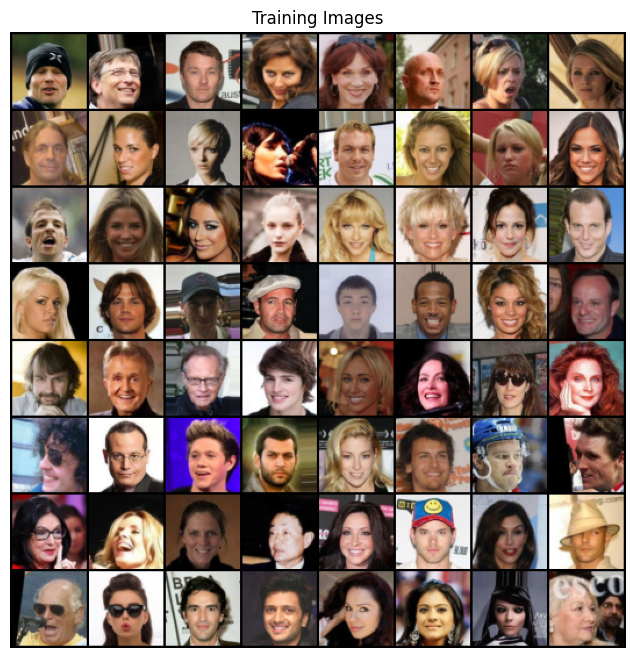

In [ ]:
# 먼저 데이터셋을 만듭니다
dataset = dset.ImageFolder(root='/content/celba/',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader를 정의해봅시다
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(dataloader)) # 반복자, 넥스트
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# ``netG`` 와 ``netD`` 에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

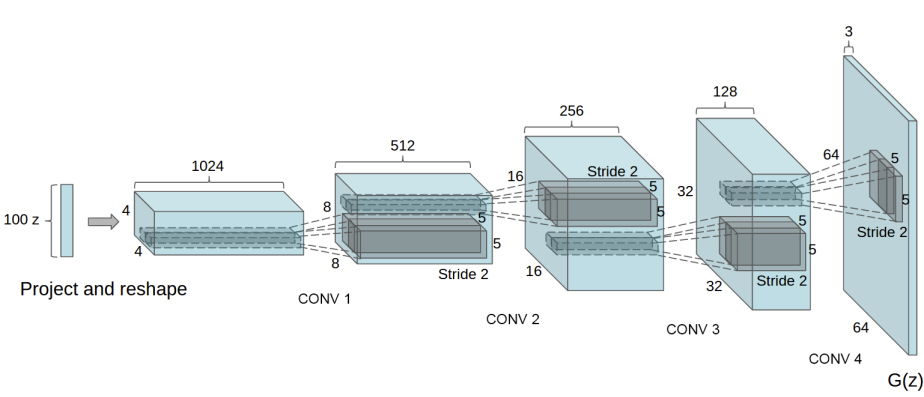

In [ ]:
# 생성자 코드
# 가중치, 편향, 활성화 함수 참고 : https://jh2021.tistory.com/3
# 시그모이드 : https://velog.io/@metterian/%EB%8C%80%EC%B2%B4-%EC%8B%9C%EA%B7%B8%EB%AA%A8%EC%9D%B4%EB%93%9CSigmoid-%ED%95%A8%EC%88%98%EA%B0%80-%EB%AD%94%EB%8D%B0
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False), # nz: z 입력 벡터의 길이, ngf : 특징 데이터의 크기, 커널, 스트라이드, 패딩, 편향(성향)
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# 생성자를 만듭니다
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다
netG.apply(weights_init)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# 구분자 코드
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 ``(nc) x 64 x 64`` 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # 입력 텐서의 메모리를  직접 수정
            # 위의 계층을 통과한 데이터의 크기. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # 마지막 레이어에 활성 함수(이진 분류로 선형함수를 사용하면 안됨 - 로지스틱 회귀분석) 0~1 사이로 조정
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# 구분자를 만듭니다
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# ``BCELoss`` 함수의 인스턴스를 초기화합니다
criterion = nn.BCELoss() # 손실함수

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1. # 참
fake_label = 0. # 거짓

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.6264	Loss_G: 5.5242	D(x): 0.5733	D(G(z)): 0.5501 / 0.0065
[0/5][50/1583]	Loss_D: 0.1518	Loss_G: 9.1019	D(x): 0.9217	D(G(z)): 0.0040 / 0.0004
[0/5][100/1583]	Loss_D: 0.3823	Loss_G: 7.9448	D(x): 0.9391	D(G(z)): 0.2139 / 0.0011
[0/5][150/1583]	Loss_D: 1.6744	Loss_G: 9.6464	D(x): 0.9620	D(G(z)): 0.6772 / 0.0005
[0/5][200/1583]	Loss_D: 0.3973	Loss_G: 4.6041	D(x): 0.9074	D(G(z)): 0.1944 / 0.0243
[0/5][250/1583]	Loss_D: 0.6055	Loss_G: 6.2560	D(x): 0.8800	D(G(z)): 0.2903 / 0.0034
[0/5][300/1583]	Loss_D: 0.7751	Loss_G: 3.5784	D(x): 0.6289	D(G(z)): 0.0505 / 0.0525
[0/5][350/1583]	Loss_D: 0.8164	Loss_G: 4.9813	D(x): 0.8683	D(G(z)): 0.3838 / 0.0175
[0/5][400/1583]	Loss_D: 0.8127	Loss_G: 3.5314	D(x): 0.5899	D(G(z)): 0.0243 / 0.0820
[0/5][450/1583]	Loss_D: 0.5609	Loss_G: 7.1423	D(x): 0.9008	D(G(z)): 0.3159 / 0.0018
[0/5][500/1583]	Loss_D: 0.2833	Loss_G: 6.7333	D(x): 0.8117	D(G(z)): 0.0175 / 0.0037
[0/5][550/1583]	Loss_D: 0.5611	Loss_G: 5.5038	D(x): 0

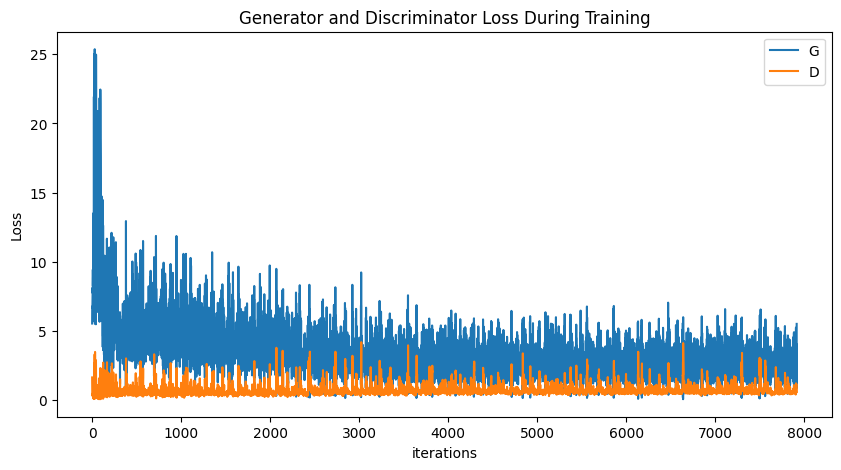

In [ ]:
# 손실값 그리기
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# 학습 과정 시각화
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

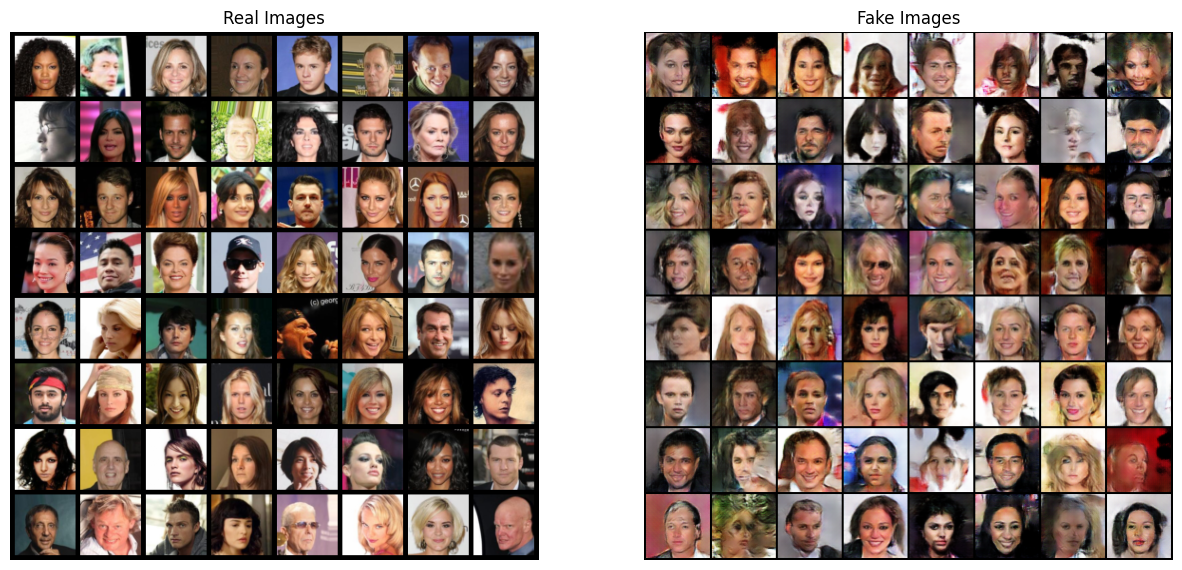

In [ ]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()